# Prostate Zones Segmentation - Baseline w/o gland mask
Train a model using the ProstateX data for training and test on the Prostate3T. This is an initial study.

In [3]:
import IPython
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
import pandas as pd
import pytorch_lightning
import torch
from torch.utils.data import DataLoader

import monai
from monai.transforms import \
    Compose, LoadImaged, AddChanneld, Orientationd, \
    NormalizeIntensityd, ScaleIntensityRangePercentilesd, \
    SpatialPadd, Spacingd, \
    RandRotated, \
    RandSpatialCropd, \
    RandFlipd, CropForegroundd, RandWeightedCropd, \
    LabelToMaskd, ScaleIntensityRanged, \
    CopyItemsd, DeleteItemsd, Lambdad, \
    RandCropByPosNegLabeld, ToTensord,  \
    DataStatsd, KeepLargestConnectedComponent, \
    AsDiscrete 
from monai.data import list_data_collate,decollate_batch
from monai.networks.layers import Norm

from monai.visualize import img2tensorboard
from monai.utils import set_determinism
from monai.inferers import sliding_window_inference

monai.config.print_config()

MONAI version: 0.6.0
Numpy version: 1.19.2
Pytorch version: 1.10.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0ad9e73639e30f4f1af5a1f4a45da9cb09930179

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.1.1
scikit-image version: 0.17.2
Pillow version: 8.1.0
Tensorboard version: 2.2.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.8.2
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.55.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.3.1
einops version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Verify System Setup
Check torch and CUDA on the system.

In [4]:
print('CUDA available: ', torch.cuda.is_available())

n_gpus = torch.cuda.device_count()
for i in range(n_gpus):
    print('GPU %d: %s' % (i, torch.cuda.get_device_name(i)))


CUDA available:  True
GPU 0: Quadro RTX 8000
GPU 1: Quadro RTX 8000
GPU 2: Quadro RTX 8000


## Set the project path

In [5]:
EXP_NAME = 'Baseline_CE'
ROOT_PATH = r'../resources/model/'
# ROOT_PATH = sys.path[0]
EXP_PATH = os.path.join(ROOT_PATH,EXP_NAME.lower())

# Create the study directory structure
if not os.path.exists(EXP_PATH):
    print('Creating experiment directory: {}'.format(EXP_PATH))
    os.mkdir(EXP_PATH)

print('Using experiment directory: {}'.format(EXP_PATH))


Using experiment directory: ../resources/model/baseline_ce


## Load the Data

In [6]:
PROSTATEX_PATH = r'../resources/data/ProstateX_data_index.csv'

df = pd.read_csv(PROSTATEX_PATH, index_col=False)
df = df.dropna(subset=['SEGM_PIRADS'])
df.drop_duplicates(inplace=True)
df = df.rename(columns={
    'SEGM_PIRADS': 'SEGM',
    'IMAGE': 'IMAGE'
})

print('Dataset contains %d entries' % len(df))
df.head(5)

Dataset contains 98 entries


,SUBJECT_ID,VISIT_ID,IMAGE,SEGM,DATASET_ID
5,4,0,/data16/public/prostate/data/public/from_tenso...,/data16/public/prostate/data/public/from_tenso...,ProstateX
8,7,0,/data16/public/prostate/data/public/from_tenso...,/data16/public/prostate/data/public/from_tenso...,ProstateX
10,9,0,/data16/public/prostate/data/public/from_tenso...,/data16/public/prostate/data/public/from_tenso...,ProstateX
15,12,0,/data16/public/prostate/data/public/from_tenso...,/data16/public/prostate/data/public/from_tenso...,ProstateX
18,15,0,/data16/public/prostate/data/public/from_tenso...,/data16/public/prostate/data/public/from_tenso...,ProstateX


In [7]:
PROSTATE3T_PATH = r'../resources/data/Prostate3T_data_index.csv'

df_test = pd.read_csv(PROSTATE3T_PATH, index_col=False)
df_test.drop_duplicates(inplace=True)

print('Dataset contains %d entries' % len(df_test))
df_test.head(5)

Dataset contains 30 entries


,SUBJECT_ID,IMAGE,SEGM,SEGM_PROSTATE,DATASET_ID
0,1,/data16/public/prostate/data/public/TCIA/Prost...,/data16/public/prostate/data/public/TCIA/Prost...,/data16/public/prostate/data/public/TCIA/Prost...,Prostate3T
1,2,/data16/public/prostate/data/public/TCIA/Prost...,/data16/public/prostate/data/public/TCIA/Prost...,/data16/public/prostate/data/public/TCIA/Prost...,Prostate3T
2,3,/data16/public/prostate/data/public/TCIA/Prost...,/data16/public/prostate/data/public/TCIA/Prost...,/data16/public/prostate/data/public/TCIA/Prost...,Prostate3T
3,4,/data16/public/prostate/data/public/TCIA/Prost...,/data16/public/prostate/data/public/TCIA/Prost...,/data16/public/prostate/data/public/TCIA/Prost...,Prostate3T
4,5,/data16/public/prostate/data/public/TCIA/Prost...,/data16/public/prostate/data/public/TCIA/Prost...,/data16/public/prostate/data/public/TCIA/Prost...,Prostate3T


In [8]:
# Convert DF to dictionary
train_data_dict = df.to_dict('records')
test_data_dict = df_test.to_dict('records')

print('Number of training files: ', len(train_data_dict))
print('Number of testing files: ', len(test_data_dict))

Number of training files:  98
Number of testing files:  30


## Setup Input Transformations

In [9]:
SPACING = (1.5,1.5,2.5)
PATCH_SIZE = (48,48,16)
MARGIN = 8
THETA = 5./180.

# Setup a weighted sampling map using the segmenation image
def map_labels(x, mapping_dict):
    for key, value in mapping_dict.items():
        x[x==key] = value
    return x

# Map TZ and AFS to CG (label 2)
TRAIN_MAPPING_FN = {3: 2, 4: 2}

# Weighted sampling func
TEST_MAPPING_FN = {1: 10, 2: 1}


train_transforms = Compose([
    LoadImaged(keys=['IMAGE', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['IMAGE', 'SEGM']),
    Orientationd(keys=['IMAGE','SEGM'], axcodes='RAS'),
    Spacingd(keys=['IMAGE', 'SEGM'], 
             pixdim=SPACING, mode=('bilinear', 'nearest'), 
             padding_mode=('reflection','reflection')),
    ScaleIntensityRangePercentilesd(keys=['IMAGE'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
    CropForegroundd(keys=['IMAGE', 'SEGM'], 
                source_key='SEGM', select_fn=lambda x: x > 0, margin=MARGIN),
    Lambdad(keys=['SEGM'], func=lambda x: map_labels(x, TRAIN_MAPPING_FN)),
    SpatialPadd(keys=['IMAGE', 'SEGM'], 
                spatial_size=PATCH_SIZE, mode=('reflect','reflect')),
    RandSpatialCropd(keys=['IMAGE', 'SEGM'], roi_size=PATCH_SIZE, random_size=False),
    RandFlipd(keys=['IMAGE', 'SEGM'], prob=0.5, spatial_axis=[0]),
    ToTensord(keys=['IMAGE', 'SEGM'])
])


test_transforms = Compose([
    LoadImaged(keys=['IMAGE', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['IMAGE', 'SEGM']),
    Orientationd(keys=['IMAGE','SEGM'], axcodes='RAS'),
    Spacingd(keys=['IMAGE', 'SEGM'], 
             pixdim=SPACING, mode=('bilinear', 'nearest'), 
             padding_mode=('reflection','reflection')),
    CropForegroundd(keys=['IMAGE', 'SEGM'], 
                    source_key='SEGM', select_fn=lambda x: x > 0, margin=MARGIN),
    ScaleIntensityRangePercentilesd(keys=['IMAGE'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
    ToTensord(keys=['IMAGE', 'SEGM'])
])



## Check Input Data

torch.Size([1, 1, 48, 38, 23])
image shape: torch.Size([48, 38, 23]), label shape: torch.Size([48, 38, 23])
image mean: 0.05985688418149948


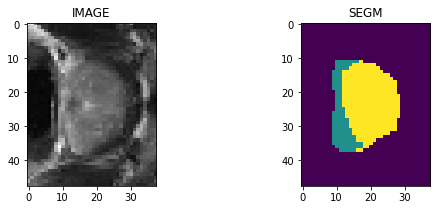

In [10]:
# check_ds = monai.data.Dataset(data=train_data_dict[:4], transform=train_transforms)
check_ds = monai.data.Dataset(data=test_data_dict[:1], transform=test_transforms)

check_loader = DataLoader(check_ds, batch_size=3, num_workers=0, collate_fn=list_data_collate)
check_data = monai.utils.misc.first(check_loader)
print(check_data['IMAGE'].shape)

num_display = 10
if check_data['IMAGE'].shape[0] < num_display:
    num_display = check_data['IMAGE'].shape[0]

for i in range(num_display):
    image = check_data['IMAGE'][i][0]
    label = check_data['SEGM'][i][0]
    print('image shape: {}, label shape: {}'.format(image.shape, label.shape))
    print('image mean: {}'.format(np.mean(image.numpy())))

    slice_num = image.shape[2]//3
    
    plt.figure('check', (9, 3))
    plt.subplot(1, 2, 1)
    plt.title('IMAGE')
    plt.imshow(image[:,:,slice_num], cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title('SEGM')
    plt.imshow(label[:,:,slice_num])
    plt.show()

## Create a Data Cache for Training and Validation Data

In [11]:
train_ds = monai.data.CacheDataset(
    data=train_data_dict, transform=train_transforms, cache_rate=1.0, num_workers=10
)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4, collate_fn=list_data_collate)

Loading dataset: 100%|██████████| 98/98 [00:24<00:00,  4.04it/s]


## Create Dataset for Testing Data

In [12]:
test_ds = monai.data.CacheDataset(
    data=test_data_dict, transform=test_transforms, cache_rate=1.0, num_workers=10
)

test_loader = DataLoader(test_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 30/30 [00:03<00:00,  8.40it/s]


In [2]:
class PZSegm(pytorch_lightning.LightningModule):

    def __init__(self, dropout=0.0):
        super().__init__()
        
        self.dropout = dropout
        
        self._model = monai.networks.nets.UNet(
            dimensions=3, 
            in_channels=1, 
            out_channels=3, 
            channels=(16, 32, 64, 128),
            strides=(2, 2, 2), 
            num_res_units=2, 
            norm=Norm.BATCH,
            dropout=self.dropout
        )
        
        self.loss_function = torch.nn.CrossEntropyLoss()
        self.one_hot_transform = monai.transforms.AsDiscrete(to_onehot=True, n_classes=3)
        self.val_dice_function = monai.metrics.DiceMetric(include_background=False)
        
    def forward(self, x):
        return self._model(x)

    
    def prepare_data(self):
        # set deterministic training for reproducibility
        set_determinism(seed=0)
    
    
    def training_step(self, batch, batch_idx):
        images = batch["IMAGE"]
        labels = batch["SEGM"]
        
        outputs = self.forward(images)
        
        loss = self.loss_function(outputs, torch.squeeze(labels, dim=1).long())
        
        if batch_idx<1:
            img2tensorboard.plot_2d_or_3d_image(data=images, 
                            step=self.current_epoch, 
                            writer=self.logger.experiment,
                            tag='Train/Input')
            img2tensorboard.plot_2d_or_3d_image(data=torch.argmax(outputs, dim=1, keepdim=True), 
                            step=self.current_epoch, 
                            writer=self.logger.experiment,
                            tag='Train/Output')        
        
        return {"loss": loss}
        
    
    def training_epoch_end(self, outputs):
        # Only add the graph at the first epoch
        if self.current_epoch==1:
            sample_input = torch.rand((1,1,64,64,8))
            self.logger.experiment.add_graph(
                PZSegm(), 
                [sample_input])
        
        # Calculate the average loss
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Train/Loss', avg_loss, self.current_epoch)
    
    
    def validation_step(self, batch, batch_idx):
        images = batch["IMAGE"]
        labels = batch["SEGM"]
        
        roi_size = (128, 128, 80)
        sw_batch_size = 4
        outputs = sliding_window_inference(images, roi_size, sw_batch_size, self.forward)

        loss = self.loss_function(outputs, torch.squeeze(labels, dim=1).long())

        argmax = torch.argmax(outputs, dim=1, keepdim=True)
    
        y_pred_onehot = torch.stack([self.one_hot_transform(i) for i in decollate_batch(argmax)])
        y_onehot = torch.stack([self.one_hot_transform(i) for i in decollate_batch(labels)])
        
        val_dice = self.val_dice_function(y_pred_onehot,y_onehot)        
                
        if batch_idx<1:
            img2tensorboard.plot_2d_or_3d_image(data=images, 
                            step=self.current_epoch, 
                            writer=self.logger.experiment,
                            tag='Validation/Input')
            img2tensorboard.plot_2d_or_3d_image(data=argmax, 
                            step=self.current_epoch, 
                            writer=self.logger.experiment,
                            tag='Validation/Output')

        return {"val_loss": loss, "val_dice": val_dice}

    
    def validation_epoch_end(self, outputs):
        # Calculate the average loss
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        total_dice = torch.stack([x['val_dice'][0] for x in outputs])
        filtered_total_dice = total_dice[~torch.any(total_dice.isnan(),dim=1)]
        avg_dice = filtered_total_dice.mean()
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Val/Loss', avg_loss, self.current_epoch)
        self.logger.experiment.add_scalar('Val/Dice', avg_dice, self.current_epoch)
        self.log('val_loss',avg_loss) # save best model according to this

    
    def configure_optimizers(self):
        opt = torch.optim.Adam(self._model.parameters(), lr=5e-4)
        scheduler = {'scheduler': torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=10, gamma=0.98),
                     'name': 'Learning Rate'}
        return [opt], [scheduler]
    
    

In [18]:
from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = PZSegm().to(device)
summary(model, (1,96,96,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 16, 48, 48, 16]             448
            Conv3d-2       [-1, 16, 48, 48, 16]             448
       BatchNorm3d-3       [-1, 16, 48, 48, 16]              32
           Dropout-4       [-1, 16, 48, 48, 16]               0
             PReLU-5       [-1, 16, 48, 48, 16]               1
            Conv3d-6       [-1, 16, 48, 48, 16]           6,928
       BatchNorm3d-7       [-1, 16, 48, 48, 16]              32
           Dropout-8       [-1, 16, 48, 48, 16]               0
             PReLU-9       [-1, 16, 48, 48, 16]               1
     ResidualUnit-10       [-1, 16, 48, 48, 16]               0
           Conv3d-11        [-1, 32, 24, 24, 8]          13,856
           Conv3d-12        [-1, 32, 24, 24, 8]          13,856
      BatchNorm3d-13        [-1, 32, 24, 24, 8]              64
          Dropout-14        [-1, 32, 24

## Train the Model Using Lightning Training Loop

In [13]:
MODEL_PATH = os.path.join(EXP_PATH,'saved_model')
print('MODEL_PATH={}'.format(MODEL_PATH))

MODEL_PATH=../resources/model/baseline_ce/saved_model


In [15]:
# initialise the LightningModule
model = PZSegm(dropout=0.3)

# set up loggers and checkpoints
tb_logger = pytorch_lightning.loggers.TensorBoardLogger(
    save_dir=os.path.join(MODEL_PATH,'logs')
)

lr_monitor = pytorch_lightning.callbacks.LearningRateMonitor(logging_interval='epoch')

checkpoint_callback = pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint(
    dirpath=MODEL_PATH,
    filename="{epoch:04d}-{val_loss:.2f}",
    monitor='val_loss',
    save_last=True,
    save_top_k=2,
    mode='min'
)

# check for last checkpoint
resume_checkpoint = None
if os.path.exists(os.path.join(MODEL_PATH,'last.ckpt')):
    resume_checkpoint = os.path.join(MODEL_PATH,'last.ckpt')

# initialise Lightning's trainer.
trainer = pytorch_lightning.Trainer(
    gpus=[0],
    max_epochs=3000,
    logger=tb_logger,
    callbacks=[lr_monitor,checkpoint_callback],
    num_sanity_val_steps=1,
    check_val_every_n_epoch=10,
    resume_from_checkpoint=resume_checkpoint
)

# train
trainer.fit(model, train_dataloader=train_loader, val_dataloaders=test_loader)
# IPython.display.clear_output()

/home1/jz729/anaconda3/envs/monai_pirads/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Checkpoint directory /data16/public/prostate/pirads-sttr/phase1_model/pz_segm/baseline_ce/saved_model exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name          | Type             | Params
---------------------------------------------------
0 | _model        | UNet             | 1.2 M 
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
Restored states from the checkpoint file at /data16/public/prostate/pirads-sttr/phase1_model/pz_segm/baseline_ce/saved_model/last.ckpt


Validation sanity check: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Saving latest checkpoint...


1

## Perform Inference on the Data


In [25]:
RESULTS_PATH = os.path.join(EXP_PATH,'results')

if not os.path.exists(RESULTS_PATH):
    print('Creating experiment directory: {}'.format(RESULTS_PATH))
    os.mkdir(RESULTS_PATH)

print('Using experiment directory: {}'.format(RESULTS_PATH))

Using experiment directory: ../resources/model/baseline_ce/results


In [16]:
# Load 
model_path = os.path.join(MODEL_PATH,'last.ckpt')
print('Loading saved model from: {}'.format(model_path))

model = PZSegm.load_from_checkpoint(model_path)

Loading saved model from: ../resources/model/baseline_ce/saved_model/last.ckpt


In [19]:
from monai.inferers import sliding_window_inference

# Import utils
import segmplot
import visualization as viz
import time

def run_inference_and_evaluate(model, batch, roi_size, plot_images=False, save_output=False, sw_batch_size=4):
    """Inference and evaluation function for PZ segmentation.
    
    """
    
    # Use MONAI one_hot transform
    one_hot_transform = monai.transforms.AsDiscrete(to_onehot=True, n_classes=3)
    
    with torch.no_grad():        
        
        x = test_data['IMAGE'].to(device)
        y = test_data['SEGM'].cpu()
        
        start_time = time.time()
        y_pred = sliding_window_inference(x, roi_size, sw_batch_size, model)
        stop_time = time.time()
        
        inference_time = stop_time-start_time
        
        argmax = torch.argmax(y_pred, dim=1, keepdim=True)
        argmax = argmax.detach().cpu()
        
        y_onehot = torch.stack([one_hot_transform(i) for i in decollate_batch(y)])
        y_pred_onehot = torch.stack([one_hot_transform(i) for i in decollate_batch(argmax)])        

        # Evaluate segmentation metrics
        eval_list = list()
        zonal_bounds, zonal_ids = viz.compute_pirads_zone_bounds(y[0,0,...].numpy())
        for b, zid in zip(zonal_bounds, zonal_ids):
                    
            zone_pred_onehot = y_pred_onehot[...,slice(b[0], b[1])]
            zone_onehot = y_onehot[...,slice(b[0], b[1])]
            
            dice_values, hd_values, mad_values = viz.compute_evaluation_metrics(
                y_pred=zone_pred_onehot, y=zone_onehot
            )
        
            df_metrics = pd.DataFrame()
            df_metrics['ROI'] = ['PZ','CG']
            df_metrics['ROI_VALUE'] = np.arange(len(dice_values))+1
            df_metrics['DICE'] = dice_values
            df_metrics['HD95'] = hd_values
            df_metrics['MAD'] = mad_values
            df_metrics['ZONAL_ID'] = zid
            eval_list.append(df_metrics)

        # Concat all the zonal segm results
        df_eval = pd.concat(eval_list)
        # Global eval values
        df_eval['INFERENCE_TIME'] = inference_time
        df_eval['DATASET_ID'] = test_data['DATASET_ID'][0]
        df_eval['SUBJECT_ID'] = test_data['SUBJECT_ID'][0].cpu().numpy()
        df_eval['IMAGE'] = test_data['IMAGE_meta_dict']['filename_or_obj'][0]
        df_eval['SEGM'] = test_data['SEGM_meta_dict']['filename_or_obj'][0]
        
        
        if plot_images:
            # Ensure that image is CxHxWxD
            image = x[0,...].cpu().numpy()
            segm = y[0,...].cpu().numpy()
            pred = y_pred_onehot[0,...].cpu().numpy()
            
            # axial plot
            plot_axial = segmplot.PlotSegmentation(
                num_slices=3, 
                slice_spacing=1, 
                slice_axis=3, 
            )
            plt.figure('segm', (20,5))
            plot_axial(image, [pred],  cmap_name=['tab10'])
            plt.show()
            
            plt.figure('segm', (20,5))
            plot_axial(segm, [pred], cmap_name=['tab10'])
            plt.show()
            
            # sagittal plot
            plot_sagittal = segmplot.PlotSegmentation(
                num_slices=3, 
                slice_spacing=6, 
                slice_axis=1, 
            )
            
            plt.figure('segm', (20,5))
            plot_sagittal(segm, [pred], cmap_name=['tab10'])
            plt.show()

        
        # Write data out
        if save_output:
            test_data['PRED'] = argmax
            # save inference transforms
            save_transforms = Compose([
                monai.transforms.AsDiscreted(keys="PRED", to_onehot=True, n_classes=3),
                monai.transforms.Invertd(
                    keys="PRED",
                    transform=test_transforms,
                    orig_keys="IMAGE",
                    orig_meta_keys="IMAGE_meta_dict",
                    meta_keys="PRED_meta_dict",
                    meta_key_postfix="meta_dict",
                    nearest_interp=False,
                    to_tensor=True,
                ),
                monai.transforms.AsDiscreted(keys="PRED", argmax=True),
                monai.transforms.SaveImaged(keys="PRED", meta_keys="PRED_meta_dict", 
                                            output_dir=RESULTS_PATH, output_postfix='infer_seg', 
                                            resample=False),])
            
            d = [save_transforms(i) for i in decollate_batch(test_data)]
            
        return df_eval

In [24]:
roi_size = (128, 128, 64)

model.eval()
device = torch.device("cuda:0")
model.to(device)

sub_idx = 0

evaluation_results = list()
for i, test_data in enumerate(test_loader):
#     if i != sub_idx:
#         continue
        
    print('Evaluating Subject {}...'.format(i+1))
    df_eval = run_inference_and_evaluate(
        model=model, 
        batch=test_data, 
        roi_size=roi_size, 
        plot_images=False, 
        save_output=False
    )
    evaluation_results.append(df_eval)
    
df_results = pd.concat(evaluation_results)

CSV_NAME = EXP_NAME
print('Using CSV_NAME name: {}'.format(CSV_NAME))
df_results['EXPERIMENT_ID'] = CSV_NAME

Evaluating Subject 1...


/home1/jz729/anaconda3/envs/monai_pirads/lib/python3.8/site-packages/monai/metrics/utils.py:195: UserWarning: ground truth is all 0, this may result in nan/inf distance.
  warnings.warn("ground truth is all 0, this may result in nan/inf distance.")
/home1/jz729/anaconda3/envs/monai_pirads/lib/python3.8/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above
/home1/jz729/anaconda3/envs/monai_pirads/lib/python3.8/site-packages/monai/metrics/utils.py:199: UserWarning: prediction is all 0, this may result in nan/inf distance.
  warnings.warn("prediction is all 0, this may result in nan/inf distance.")


Evaluating Subject 2...
Evaluating Subject 3...
Evaluating Subject 4...
Evaluating Subject 5...
Evaluating Subject 6...
Evaluating Subject 7...
Evaluating Subject 8...
Evaluating Subject 9...
Evaluating Subject 10...
Evaluating Subject 11...
Evaluating Subject 12...
Evaluating Subject 13...
Evaluating Subject 14...
Evaluating Subject 15...
Evaluating Subject 16...
Evaluating Subject 17...
Evaluating Subject 18...
Evaluating Subject 19...
Evaluating Subject 20...
Evaluating Subject 21...
Evaluating Subject 22...
Evaluating Subject 23...
Evaluating Subject 24...
Evaluating Subject 25...
Evaluating Subject 26...
Evaluating Subject 27...
Evaluating Subject 28...
Evaluating Subject 29...
Evaluating Subject 30...


In [22]:
df_results.to_csv(os.path.join(RESULTS_PATH,'{}_results.csv'.format(CSV_NAME)), index=False)
print(os.path.join(RESULTS_PATH,'{}_results.csv'.format(CSV_NAME)))

../resources/model/baseline_ce/results/Baseline_CE_results.csv


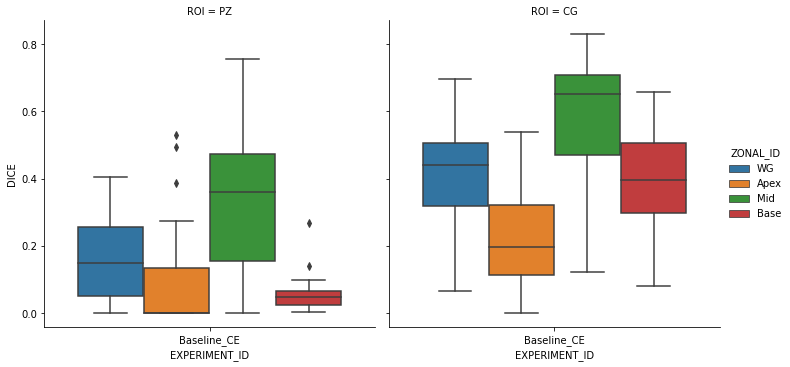

In [20]:
import seaborn as sns
ax = sns.catplot(
    data=df_results,
    x="EXPERIMENT_ID", 
    y="DICE", 
    hue="ZONAL_ID", 
    col="ROI", 
    kind='box'
)